
# Finite Element Method for Heat Exchangers

Suppose we have a couple of fluid streams exchanging heat (or mass) and want to compute the amount of heat (or mass) exchanged under given conditions of flow configuration and overall heat transfer coefficient U and area through the process. Furthermore, the streams are real -- defined numerically by points (Q,T) or an interpolate, instead of constant stream heat capacity. We want a method that converges with spatial resolution and converges with time for steady-state boundary conditions, and that hopefully gives a reasonable guess for transient conditions. Let's start with some assumptions:

- We want a method that is first order in time, and preferably explicit.
- The method may be spatially implicit.
- The inlets (fluid state and rate of change) are specified as a boundary condition.
- We have all the information we need about U, A, cross-section area, mass flow rate, and density
- It is okay to violate transient conservation of energy insofar as we choose to treat flow as incompressible.
- Assume the fluid state in a given cross-section is uniform, so we are not concerned with spatial resolution of the boundary layer, mixing, etc. 
- Assume that only advection acts to carry information downstream, ie. flow is fast enough to neglect heat transfer between points in the same stream.

As a result of some of the assumptions, it is possible for the method to overshoot, so let's keep the time step smallish.

The obvious starting point is to draw a cell with some $U \Delta A$, write out the transient first law, and extract the relevant equations for the rate of change of state. I'm going to define states at the inlet and outlet to the cell. So we have for one cell

$$ \Delta Q = \dot{m} (h_{in} - h_{out}) + \int_{cell} \dot{h} dm $$

Now we need to provide an finite element approximation of the mass integral / time rate of change term and estimate $\Delta Q$ resulting from interaction with the other stream. First, let's use a first order central method for the integral term:

$$ \int_{cell} \dot{h} dm \approx (\rho A_c \Delta x)
  \left(\frac{1}{2}\right)\left(\dot{h}_{in}+\dot{h}_{out}\right) $$
  
We will decide later how to collect the time rate of change terms. Meanwhile, the local heat transfer rate is

$$ Q = \epsilon Q_{max}, $$

where $Q_{max}$ is found for counter-flow by trying to take each stream to equilibrium with the other stream's inlet, and seeing which side is limiting. If we have local estimates of stream heat capacity, so much the better, as we can use the textbook definition. For counter-flow, effectiveness can be computed as

$$ \epsilon(NTU, C_r) = \begin{cases} 
     \frac {1 - \exp[-NTU(1 - C_{r})]}{1 - C_{r}\exp[-NTU(1 - C_{r})]} & C_r < 1 \\[0.5ex]
     \frac{NTU}{1+NTU} & C_r = 1 
     \end{cases} $$
     
Our first numerical task is to make this function behave well with respect to $C_r$. Let's visualize the function.

In [9]:
import numpy
from numpy import exp
def counterflow_effectiveness(ntu, c_r):
    a = exp(-(ntu * (1-c_r)))
    return (1 - a) / (1 - c_r * a)
def counterflow_effectiveness_matched(ntu):
    return ntu / (1 + ntu)

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


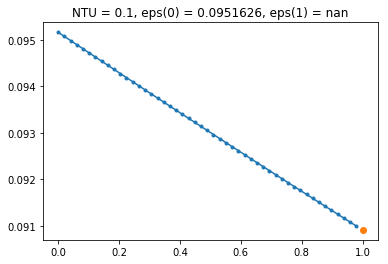

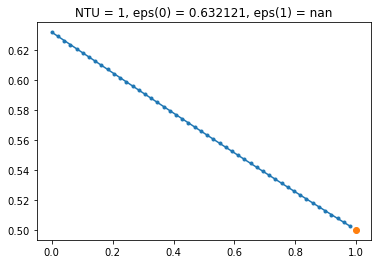

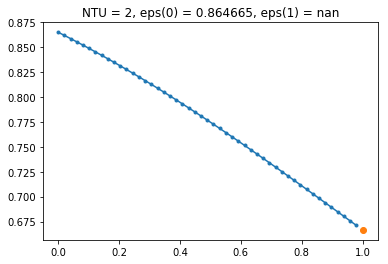

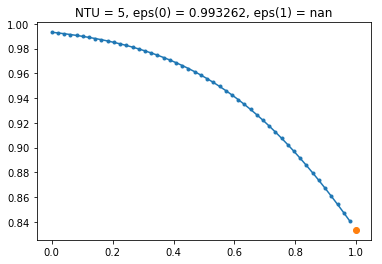

In [15]:
import matplotlib.pyplot as plt
for ntu in [0.1, 1, 2, 5]:
    c_r = numpy.linspace(0,1)
    ce = counterflow_effectiveness(ntu, c_r)
    c1 = counterflow_effectiveness_matched(ntu)
    plt.figure()
    plt.plot(c_r, ce, '.-')
    plt.plot(1, c1, 'o')
    plt.title("NTU = {:g}, eps(0) = {:g}, eps(1) = {:g}".format(
        ntu, ce[0], ce[-1]))
plt.show()

What we see here is that as long as $NTU < 2$, we can treat effectiveness as linear in $C_r$. Our goal is indeed to have a spatially refined method, perhaps we can require the grid to be fine enough so that in each cell, $NTU < 1$. If this requires a very large number of cells, the effectiveness is nearly 1 already, so we shouldn't worry too much.

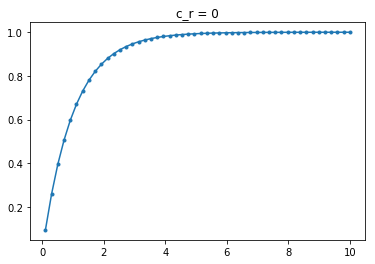

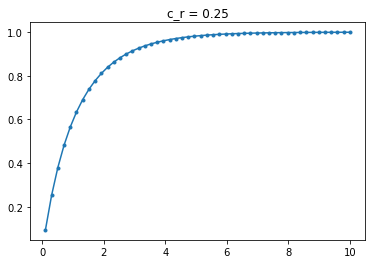

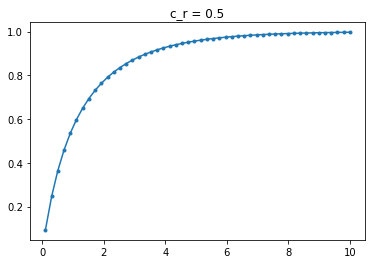

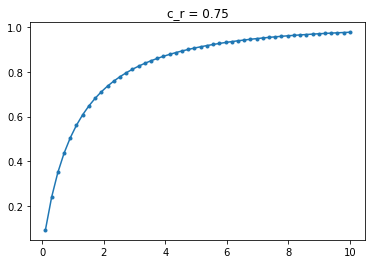

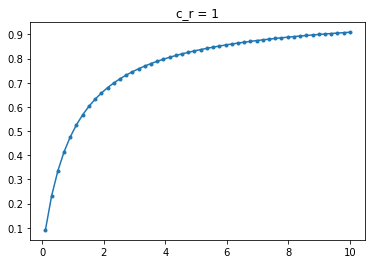

In [20]:
import matplotlib.pyplot as plt
for c_r in numpy.linspace(0.,1.,5):
    ntu = numpy.linspace(0.1, 10)
    if c_r < 1:
        ce = counterflow_effectiveness(ntu, c_r)
    else:
        ce = counterflow_effectiveness_matched(ntu)
    plt.figure()
    plt.plot(ntu, ce, '.-')
    plt.title("c_r = {:g}".format(
        c_r))
plt.show()

What we see here is that $\epsilon$ has the same trends with respect to $NTU$ regardless of $C_r$, except the shoulder moves out. This suggests we try fitting functions that have the same slope at $NTU = 0$ regardless of $C_r$, always converge to 1 as $NTU$ grows, but that "grow more slowly" as $C_r$ increases. For numerical uses, a satisfying fit ...